In [55]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy
from scipy import stats
import torch
import matplotlib.pyplot as plt

import torch
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms

from torch.distributions import Gamma, Normal, Bernoulli, MultivariateNormal, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform

from tqdm.auto import trange

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Uniform
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms


In [56]:
# Download MNIST training data and convert to float32
# Only use a subset of the images
N = 10000
X3d_true = MNIST(root='.', train=True, transform=None, download=True).data
X3d_true = X3d_true.type(torch.float32)
X3d_true = X3d_true[:N]
_, H, W = X3d_true.shape

In [57]:
def random_line_mask(num_samples, 
                     mask_size=(28, 28), 
                     lw=2):
    """
    Make a mask from a line through the center of the image.

    Args:
        num_samples: number of masks to generate
        mask_size: pixels by pixels
        lw: line width in pixels

    Returns:
        masks: (num_samples,) + mask_size array of binary masks

    """
    # Sample random orientations for each line
    us = Normal(0, 1).sample((num_samples, 2))
    us /= torch.norm(us, dim=1, keepdim=True)

    # Get distance of each xy coordinate to the line
    # this is the norm of (x, y) - (xp, yph) where (xp, yp)
    # is the projection onto the line
    X, Y = torch.meshgrid(torch.arange(mask_size[0]), 
                          torch.arange(mask_size[1]))
    xy = torch.column_stack([X.ravel(), Y.ravel()])
    xy = xy - torch.tensor(mask_size) / 2.0
    
    # Project onto the line
    # xpyp.shape == (num_samples, num_points, 2)
    xpyp = (us @ xy.T).unsqueeze(2) * us.unsqueeze(1)  
    dist = torch.norm(xy - xpyp, dim=2)

    # Make masks based on a distance threshold
    return (dist < lw).reshape((num_samples,) + mask_size)
    

def random_circle_mask(num_samples, 
                       mask_size=(28, 28),
                       std_origin=3.0,
                       mean_radius=3.0,
                       df_radius=7.0):
    """
    Sample random circular masks.

    Args:
        num_samples: number of masks to generate
        mask_size: mask size in pixels
        std_origin: standard deviation of the origin in pixels
        mean_radius: mean radius of the circular masks
        df_radius: degrees of freedom of a chi^2 distribution on radii.

    Returns:
        masks: (num_samples,) + mask_size array of binary masks
    """
    centers = Normal(0, std_origin).sample((num_samples, 2))
    radii = 0.1 + Gamma(df_radius / 2,
                      df_radius / mean_radius / 2.0).sample((num_samples,))

    # Determine whether each point is inside the corresponding circle
    X, Y = torch.meshgrid(torch.arange(mask_size[0]),
                          torch.arange(mask_size[1]))
    X = X - mask_size[0] / 2.0
    Y = Y - mask_size[1] / 2.0
    xy = torch.column_stack([X.ravel(), Y.ravel()]) # (num_points, 2)
    dist = torch.norm(centers.unsqueeze(1) - xy, dim = 2)
    return  (dist < radii.unsqueeze(1)).reshape((num_samples,) + mask_size)


def random_speckle_mask(num_samples,
                        mask_size=(28, 28),
                        p_missing=0.1):
    """
    Sample a random speckle mask where each pixel is missing with equal 
    probability.

    Args:
        num_samples: number of masks to sample
        p_speckle: probability that a pixel is missing

    Returns:
        masks: (num_samples,) + mask_size binary array
    """
    masks = Bernoulli(p_missing).sample((num_samples,) + mask_size)
    return masks.type(torch.BoolTensor)

In [58]:
# Make masks for each data point
line_masks = random_line_mask(N // 3)
circ_masks = random_circle_mask(N // 3)
spck_masks = random_speckle_mask(N - len(line_masks) - len(circ_masks))
mask3d = torch.cat([line_masks, circ_masks, spck_masks])[torch.randperm(N)]

# Make the training data by substituting 255 (the max value of a uint8) 
# for each missing pixel
X3d = torch.clone(X3d_true)
X3d[mask3d] = 255.0

Text(0.5, 0.98, 'Random Masks')

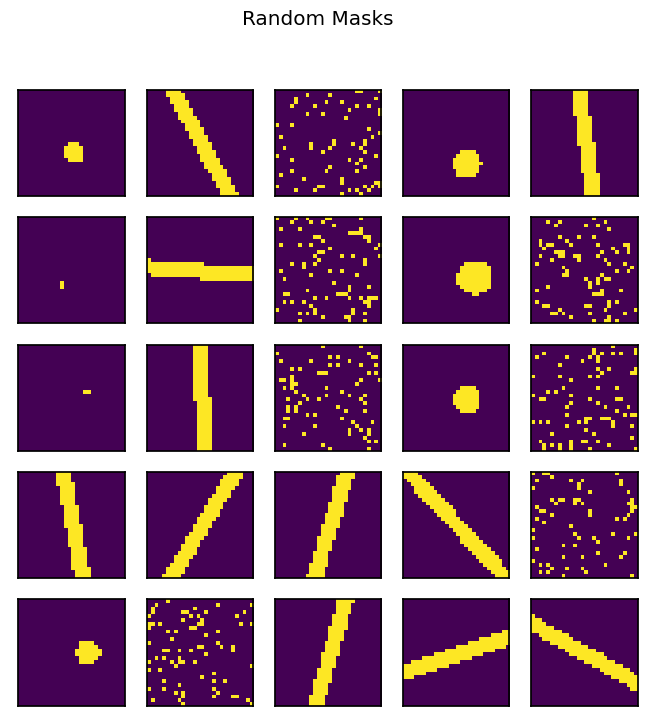

In [59]:
# Plot a few masks
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(mask3d[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("Random Masks")

Text(0.5, 0.98, 'Masked Data')

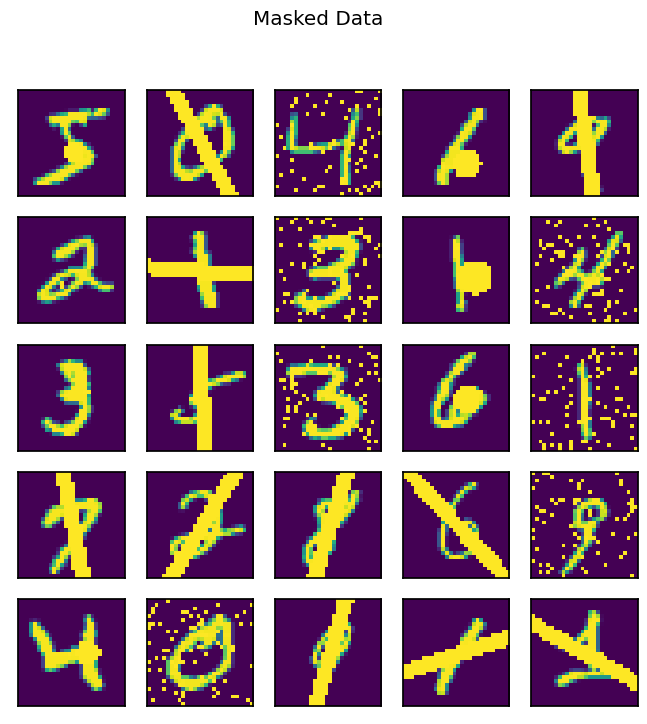

In [60]:
# Plot a few masked data points
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(X3d[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("Masked Data")

Text(0.5, 0.98, 'True Data')

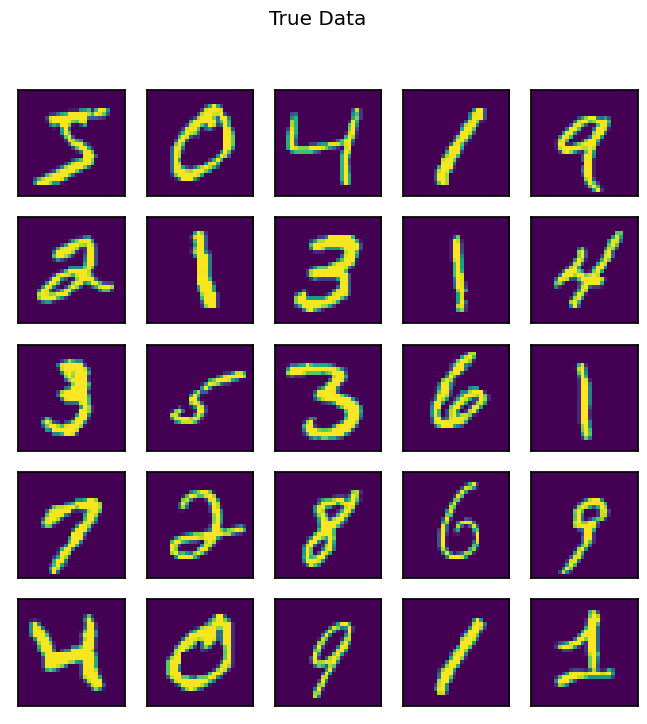

In [69]:
# Plot a few true data points
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(X3d_true[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("True Data")

In [61]:
X_true = X3d_true.reshape((N, -1))
X = X3d.reshape((N, -1))
mask = mask3d.reshape((N, -1))

In [62]:
def pca(X):
    """
    Compute the principal components and the fraction of variance explained 
    using the SVD of the scaled and centered data matrix. 

    Args:
        X: a shape (N, D) tensor

    Returns:
        pcs: a shape (D, D) tensor whose columns are the full set of D principal
            components. This matrix should be orthogonal.

        var_explained: a shape (D,) tensor whose entries are the variance 
            explained by each corresponding principal component.
    """
    ## 
    # Your code below.
    N = X.shape[0]
    X_bar = torch.mean(X, axis=0)
    Y = (X - X_bar) / np.sqrt(N)
    V, singular_values, UT = torch.linalg.svd(Y)
    eigenvalues = singular_values ** 2
    pcs = UT.T
    var_explained = eigenvalues / sum(eigenvalues)
    ##
    return pcs, var_explained

In [63]:
def plot_pca(pcs, var_explained):
    """
    Helper function to plot the principal components and the variance explained,
    aka scree plot.
    """
    # Plot the first 25 principal components
    fig, axs = plt.subplots(5, 5, figsize=(8, 8))
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(pcs[:, i * 5 + j].reshape((28, 28)), 
                            interpolation="none")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_title("PC {}".format(i * 5 + j + 1))
    plt.tight_layout()

    # Make the scree plot
    plt.figure()
    plt.plot(torch.cumsum(var_explained, dim=0))
    plt.xlabel("Number of PCs")
    plt.xlim(0, 784)
    plt.ylabel("Fraction of Variance Explained")
    plt.ylim(0, 1)
    plt.grid(True)

In [50]:
timelist = [10,20,30,50,75,85,100,120,140,160,180,200,350,500,784]

In [51]:
func1_time = []
func2_time = []
for i in timelist:
    Y=X[:500,:i]
    foo =  %timeit -o pca(Y)
    func1_time.append(np.mean(foo.timings)*1000)
    foo =  %timeit -o naive_pca(Y)
    func2_time.append(np.mean(foo.timings)*1000)

661 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
96.9 µs ± 564 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.15 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
149 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.69 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
230 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.72 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
484 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.25 ms ± 75.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.5 ms ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.76 ms ± 49.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.83 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.51 ms ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.83 ms ± 35.5 µs per loop (mean ± std. dev. of 7 

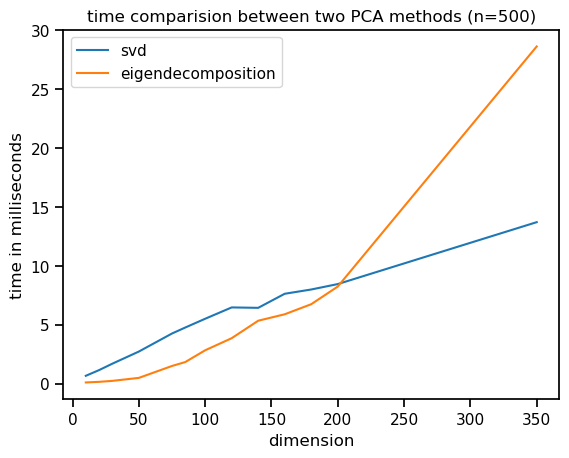

In [54]:
plt.plot(timelist[:-2],func1_time[:-2], label='svd')
plt.plot(timelist[:-2],func2_time[:-2], label='eigendecomposition')
plt.legend(loc="upper left")
plt.title('time comparision between two PCA methods (n=500)')
plt.xlabel('dimension')
plt.ylabel('time in milliseconds')
plt.show()

In [15]:
def naive_pca(X):
    N = X.shape[0]
    X_bar = torch.mean(X, axis=0)
    eigenvalues, V = torch.linalg.eig((X - X_bar).T @ (X - X_bar) / N)
    var_explained = eigenvalues / sum(eigenvalues)
    ##
    return V, var_explained

In [64]:
pcs, _ = pca(X)

Text(0.5, 0.98, 'Masked PCA')

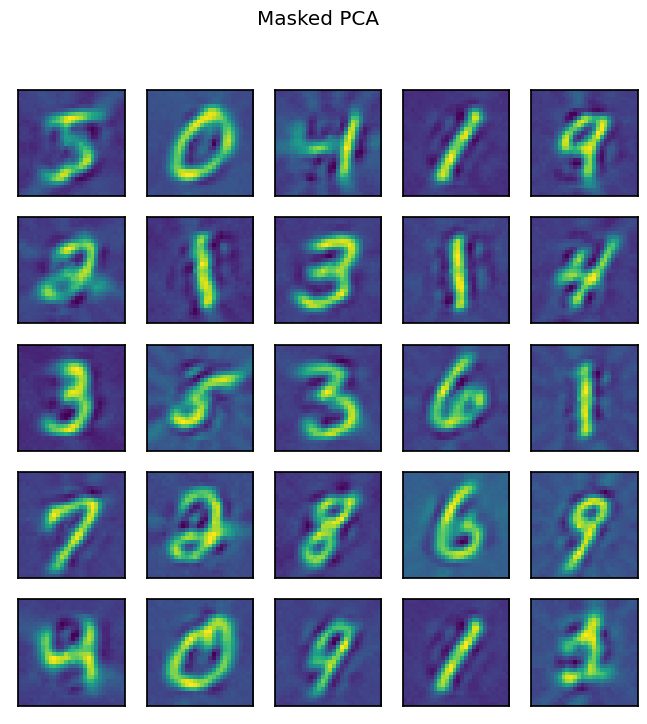

In [81]:
pcs25 = pcs[:,:50]
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow((X_true @ pcs25 @ pcs25.T).reshape(-1,28,28)[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("Masked PCA")

In [ ]:
pcs_true, _ =pca(X_true)

Text(0.5, 0.98, 'True PCA')

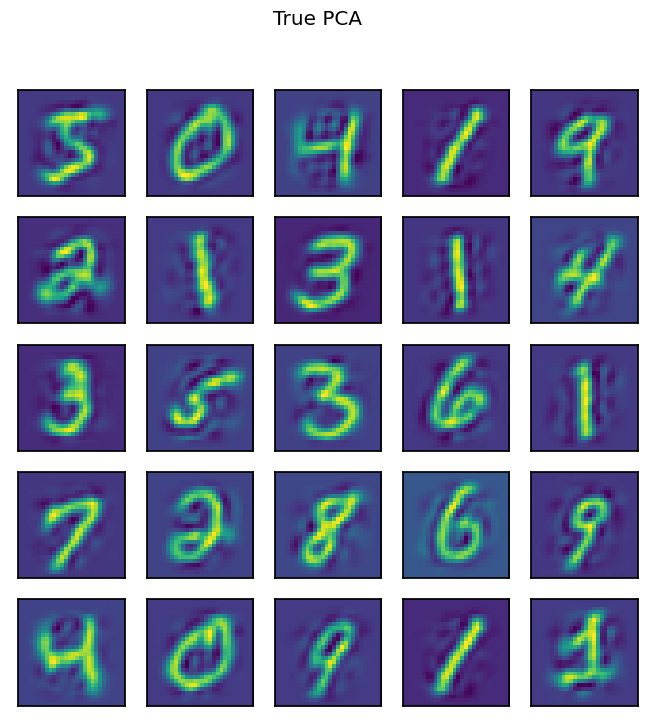

In [80]:
pcs25_true = pcs_true[:,:50]
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow((X_true @ pcs25_true @ pcs25_true.T).reshape(-1,28,28)[i * 5 + j], interpolation="none")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("True PCA")

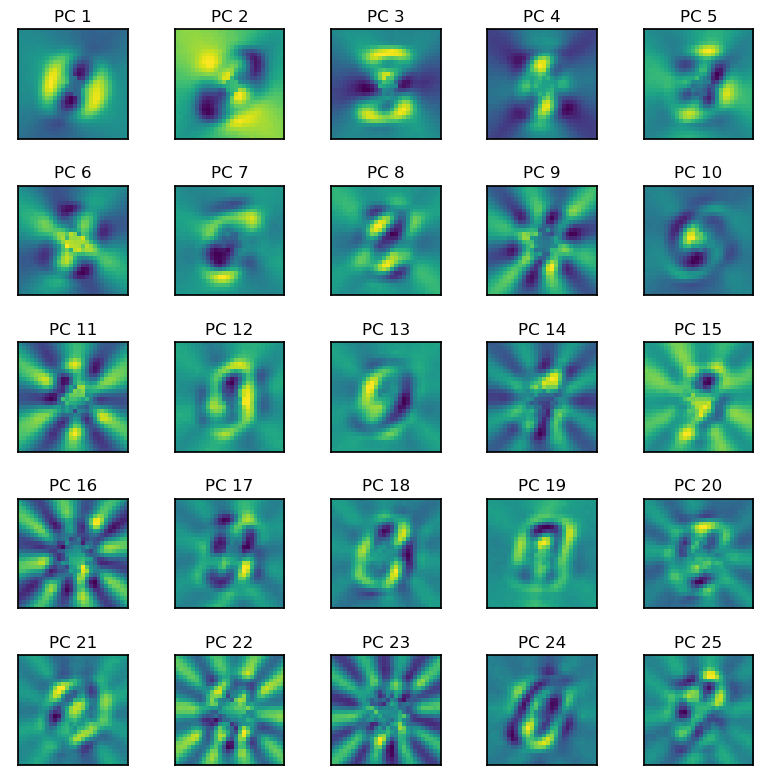

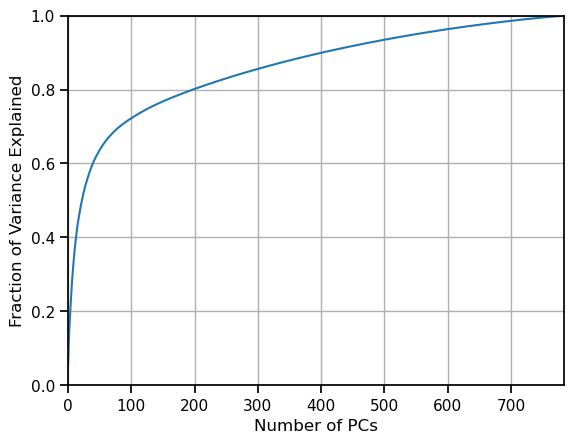

In [50]:
plot_pca(*pca(X))

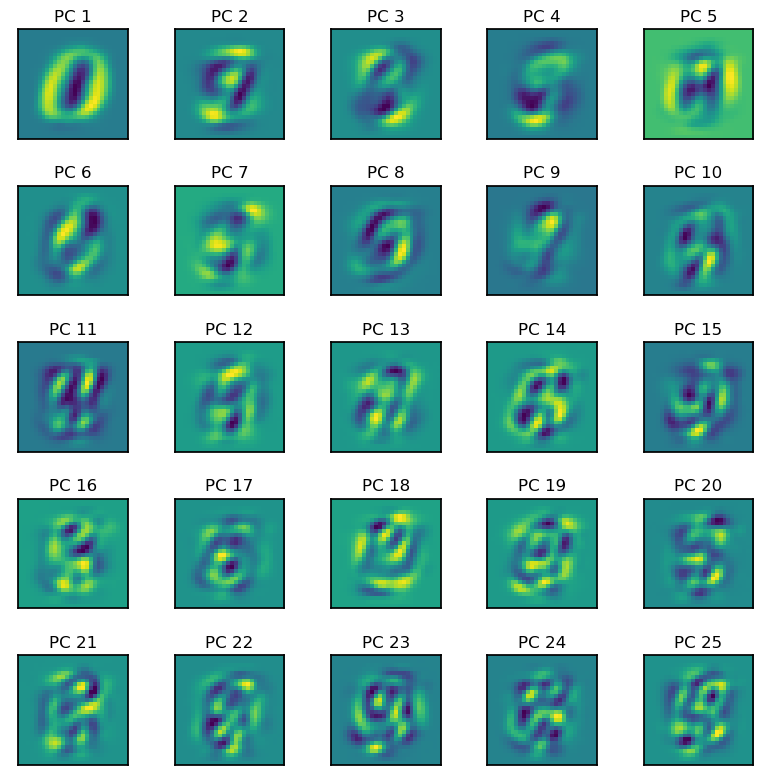

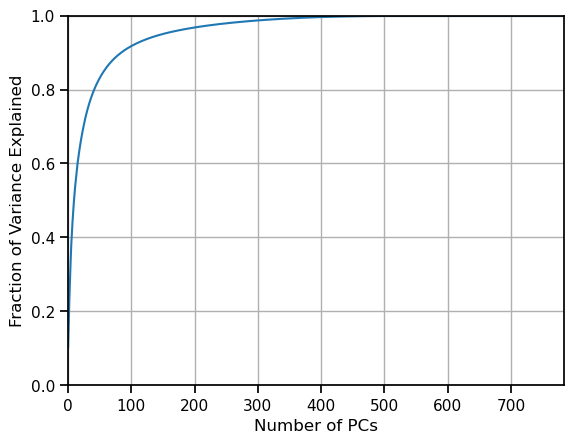

In [32]:
# Compare the results to PCA on the X_true, the flattened true data
plot_pca(*pca(X_true))

In [37]:
# Download MNIST dataset and create dataloaders. 
def binarize(imgs, integer=False):
    threshold = 127 if integer else 0.5
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

train_dataset = datasets.MNIST(root=".", train=True, download=True,
                         transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='.', train=False, download=True,
                             transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of points in dataset: {0}".format(train_dataset.data.shape[0]))
print("Number of batches per epoch: {0}".format(len(train_loader)))

Number of points in dataset: 60000
Number of batches per epoch: 938


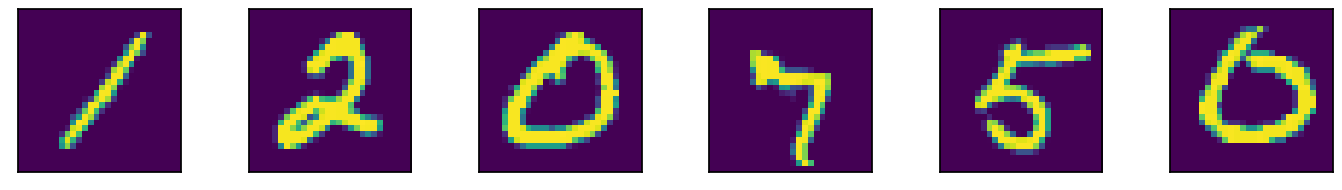

In [71]:
# Visualize some digits in the dataset.
imgs, _ = next(iter(train_loader))
#imgs = binarize(imgs)
fig, ax = plt.subplots(1, 6, figsize=(14, 14))
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imgs[i].squeeze())

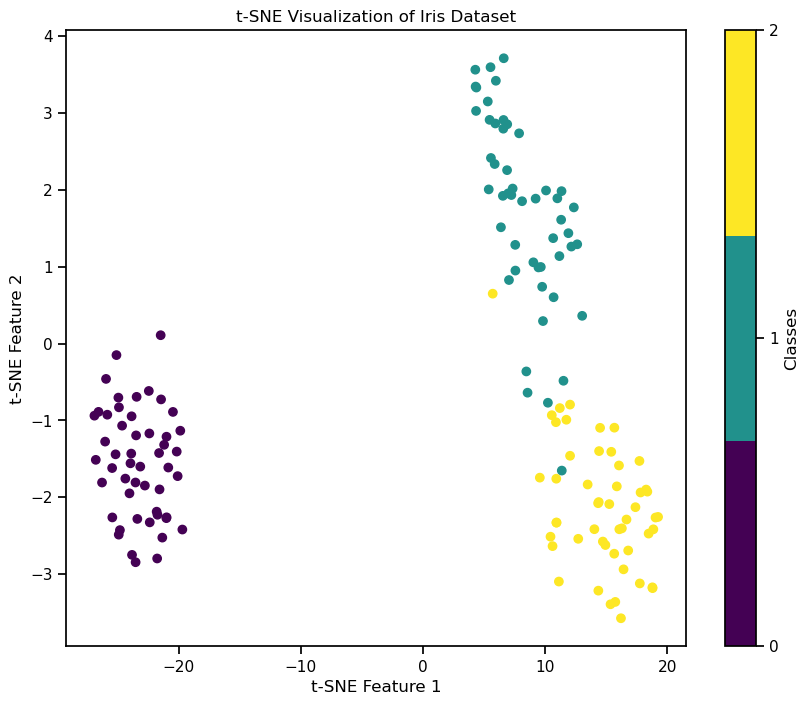

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE

# Load iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Apply t-SNE to reduce the dimensionality of the dataset
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.get_cmap("viridis", 3))
plt.colorbar(ticks=range(3), label='Classes')
plt.title("t-SNE Visualization of Iris Dataset")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.show()
